In [64]:
from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd

from mcc2 import MaximumCorrelationClassifier2 as mcc

### use vgg19 to extract sketch features

In [4]:
def deactivate(net):
    net.eval()
    for p in net.parameters():
        p.requires_grad = False  
        
use_cuda = torch.cuda.is_available()
cuda_device = 3

vgg19 = models.vgg19(pretrained=True).cuda(cuda_device)
vgg19_features = deepcopy(vgg19.features)
vgg19_classifier = deepcopy(vgg19.classifier)

# remove last layer of classifier
vgg19_classifier = nn.Sequential(*(list(vgg19_classifier.children())[:-1]))

if use_cuda:
    vgg19_features.cuda(cuda_device)
    vgg19_classifier.cuda(cuda_device)

deactivate(vgg19_features)
deactivate(vgg19_classifier)

### get sketch data and metadata

In [55]:
def list_files(path, ext='png'):
    result = [y for x in os.walk(path)
              for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

def get_label_from_path(path):
    return path.split('.')[-2].split('_')[-1]    

def get_trial_from_path(path):
    return path.split('_')[-2]

def get_subj_from_path(path):
    return path.split('/')[1]

# extract metadata
path_to_sketches = 'sketches'
sketch_paths = list_files(path_to_sketches)
labels = map(get_label_from_path,sketch_paths)
trialNum = map(get_trial_from_path,sketch_paths)
subj = map(get_subj_from_path,sketch_paths)

# organize into dataframe
X = pd.DataFrame([subj,trialNum,labels,sketch_paths])
X = X.transpose()
X.columns = ['subj','trial','label','path']

print 'Number of sketches: ' + str(len(sketch_paths))
print 'Number of subjects: ' + str(len(np.unique(subj)))

num_sketches = len(sketch_paths)

Number of sketches: 1380
Number of subjects: 35


In [6]:
def load_image(path, imsize=224, volatile=True, use_cuda=False):
    im = Image.open(path)
    im = im.convert('RGB')

    loader = transforms.Compose([
        transforms.Scale(imsize),
        transforms.ToTensor()])

    im = Variable(loader(im), volatile=volatile)
    im = im.unsqueeze(0)
    if use_cuda:
        im = im.cuda(cuda_device)
    return im

def sketch_generator(paths, imsize=224, use_cuda=use_cuda):
    for path in paths:
        sketch = load_image(path)
        label = get_label_from_path(path)
        yield (sketch, label)

# define generator
generator = sketch_generator(sketch_paths,imsize=224,use_cuda=use_cuda)

# initialize sketch and label matrices
Features = []
Labels = []
n = 0
quit = False 

# generate batches of sketches and labels    
if generator:
    while True:    
        batch_size = 64
        sketch_batch = Variable(torch.zeros(batch_size, 3, 224, 224))
        if use_cuda:
            sketch_batch = sketch_batch.cuda(cuda_device)                
        label_batch = []   
        print('Batch {}'.format(n + 1))            
        for b in range(batch_size):
            try:
                sketch, label = generator.next()
                sketch_batch[b] = sketch   
                label_batch.append(label)
            except StopIteration:
                quit = True
                print 'stopped!'
                break                
            
        if n == num_sketches//batch_size:
            sketch_batch = sketch_batch.narrow(0,0,b)
            label_batch = label_batch[:b + 1] 
        n = n + 1       

        # extract features from batch
        sketch_batch = vgg19_features(sketch_batch) 
        sketch_batch = sketch_batch.view(sketch_batch.size(0), -1)
        sketch_batch = vgg19_classifier(sketch_batch)
        sketch_batch = sketch_batch.cpu().data.numpy()

        if len(Features)==0:
            Features = sketch_batch
        else:
            Features = np.vstack((Features,sketch_batch))
        Labels.append(label_batch)

        if n == num_sketches//batch_size + 1:
            break
Labels = np.array([item for sublist in Labels for item in sublist])

Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
stopped!


### Visualize feature similarity matrices

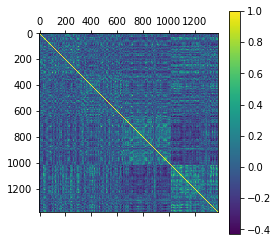

In [57]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

# normalize feature vectors & plot full image-level similarity matrix
inds = np.argsort(X.label.values)
_Features = normalize(Features[inds])
_Labels = Labels[inds]
plt.matshow(np.corrcoef(_Features))
plt.colorbar()

In [58]:
def get_class_means(X, labels):
    # load in and normalize features 
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

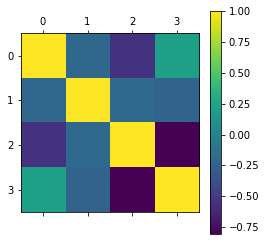

In [59]:
# plot category-level similarity matrix
means = get_class_means(Features, Labels)
plt.matshow(np.corrcoef(means))
plt.colorbar()

### Softmax classifier test

In [62]:
FEAT = _Features
LABELS = _Labels
# compute cross-validated softmax classifier accuracy 
# clf = svm.SVC(kernel='linear', C=1)
clf = linear_model.LogisticRegression(penalty='l2')
scores = cross_val_score(clf, FEAT, LABELS, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.86 (+/- 0.05)


In [65]:
# single train/test split
X_train, X_test, y_train, y_test = train_test_split(
    FEAT, LABELS, test_size=0.2, random_state=0)
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
print clf.score(X_test, y_test)

0.851449275362
